<a href="https://colab.research.google.com/github/akshaygrao77/Deep-learning-assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# Only used to show progressbar while inside an epoch
from tqdm.notebook import tqdm 

In [2]:
!pip install wandb
!wandb login

     |████████████████████████████████| 1.7 MB 7.8 MB/s 
     |████████████████████████████████| 144 kB 68.8 MB/s 
     |████████████████████████████████| 181 kB 54.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=17f8deb5e60a34c4224858a377157ea3337ac32552ebdb9bf0d8abaa7ea0f27f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import wandb

wandb.init(project="Deep learning assignment1", entity="akshaygrao")

wandb: Currently logged in as: akshaygrao (use `wandb login --relogin` to force relogin)


# **Question 1 starts**

Loading dataset from fashio-mnist

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


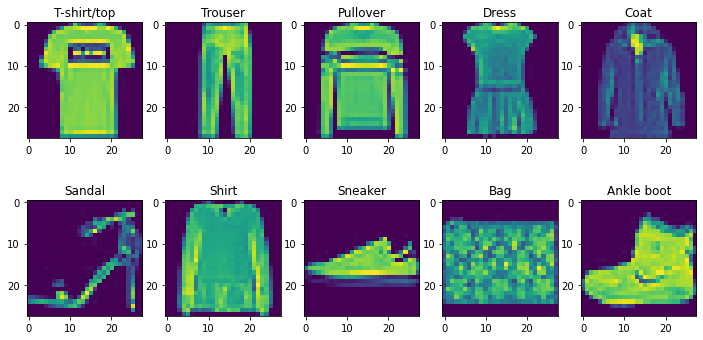

In [5]:
num_classes = 10
class_map = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
plt.figure(figsize=[12, 6])
img_list = []
class_list = []

for i in range(num_classes):
    position = np.argmax(y_train==i)
    image = x_train[position,:,:]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(class_map[i])
    img_list.append(image)
    class_list.append(class_map[i])
    
wandb.log({"Question 1": [wandb.Image(img, caption=caption) for img, caption in zip(img_list, class_list)]})

# **Question 2 starts**

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_test.shape

(10000, 28, 28)

Flatten each image into a 1-d array to input to the network

In [8]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

Normalise the array to [0,1] interval

In [9]:
x_train = x_train / 255
x_test = x_test / 255

In [10]:
x_train.shape

(60000, 784)

In [11]:
x_test.shape

(10000, 784)

Categorical encoding for labels

In [12]:
import tensorflow.keras as keras
num_categories = 10

y_train = keras.utils.to_categorical(y_train, num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)

In [13]:
y_train.shape

(60000, 10)

In [14]:
y_test.shape

(10000, 10)

In [16]:
class Activation:
    def computeSoftmaxGrad(self,H):
      grad_softmax_jacobian = np.zeros(H.shape[0]*H.shape[0]).reshape(H.shape[0],H.shape[0])
      for i in range(H.shape[0]):
        for j in range(H.shape[0]):
          if(i == j):
            grad_softmax_jacobian[i][j] = H[i]*(1-H[j])
          else:
            grad_softmax_jacobian[i][j] = -H[i]*H[j]
      return grad_softmax_jacobian
  
    def computeSigmoidGrad(self,H):
      # print("Grad Sigmoid ",H)
      # print("number of non-zeros in H:",np.count_nonzero(H))
      ret = H*(1-H)
      # print("Ret ",ret)
      # print("number of non-zeros in ret:",np.count_nonzero(ret))
      return ret 

    def computeTanhGrad(self,H):
      ret = 1 - H**2
      if(~(np.isfinite(ret).all())):
        if(np.isnan(ret).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("Gradient Tanh ret",ret)
        ret = replaceNanWithMaxAndMin(ret)
      return ret 
    
    def computeReluGrad(self,A):
       return 1.0 * (A > 0)

    def sigmoid(self, X):
      # print("Sigmoid",X)
      exp = np.exp(-X)
      # print("Exp:",exp)
      if(~(np.isfinite(exp).all())):
        if(np.isnan(exp).any()):
          print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
          print("Sigmoid X",X)
          print("Sigmoid exp before",exp)
        exp = replaceNanWithMaxAndMin(exp)
      
      ret = 1.0 / (1.0 + exp)
      # print("Ret sigmoid:",ret)
      return ret

    def relu(self,X):
      ret = np.maximum(0.0,X)
      return ret
    
    def tanh(self,X):
      ret = np.tanh(X)
      if(~(np.isfinite(ret).all())):
        if(np.isnan(ret).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("Tanh ret",ret)
        ret = replaceNanWithMaxAndMin(ret)
      return ret

    def softmax(self, X):
      Z = X-max(X)
      exps = np.exp(Z)
      if(~(np.isfinite(exps).all())):
        if(np.isnan(exps).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax X",X)
          print("softmax exps",exps)
        exps = replaceNanWithMaxAndMin(exps)
      
      sum = np.sum(exps)
      if(~(np.isfinite(sum).all())):
        if(np.isnan(sum).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax sum",sum)
        sum = replaceNanWithMaxAndMin(sum)

      ret = exps / sum
      if(~(np.isfinite(ret).all())):
        if(np.isnan(ret).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax exps",exps)
          print("softmax sum",sum)
          print("softmax ret",ret)
        ret = replaceNanWithMaxAndMin(ret)

      if(~(np.isfinite(ret).all())):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("softmax X",X)
          print("softmax np.sum(exps)",np.sum(exps))
          print("softmax exps",exps)
      return ret

In [17]:
def replaceNanWithMaxAndMin(X):
    if(np.isscalar(X)):
      if(X == float("inf")):
          X = 1e+306
      elif(X == float("-inf")):
          X = 1e-306
      else:
        X = 1e-306
    else:
      if(~(np.isfinite(X).all())):
        nan_indices = np.argwhere(~(np.isfinite(X))).flatten()
        # print("nan_indices",nan_indices)
        for ind in nan_indices:
          # print("Ind",ind)
          # print("X[ind]",X[ind])
          if(X[ind] == float("inf")):
            X[ind] = 1e+306
          elif(X[ind] == float("-inf")):
            X[ind] = 1e-306
          else:
            X[ind] = 1e-306
    return X
      

In [18]:
class InputLayer:
  number_of_inputs=0

  def __init__(self,number_of_inputs) -> None:
      self.number_of_inputs = number_of_inputs

In [19]:
class Layer:
  number_of_neurons=0
  activation = 'sigmoid'
  # Weight intialization before layer to which current layer is defined(hence invalid on input layer)
  weight_initialization= None
  
  def __init__(self,number_of_neurons,activation) -> None:
      self.number_of_neurons = number_of_neurons
      self.activation = activation
      self.weight_initialization= None

In [20]:
def xavierWeightInitialisation(num_previous_layer,num_next_layer): 
  # calculate the range for the weights
  lower, upper = -(math.sqrt(6.0) / math.sqrt(num_previous_layer + num_next_layer)), (math.sqrt(6.0) / math.sqrt(num_previous_layer + num_next_layer))
  # generate random numbers
  numbers = np.random.rand(num_previous_layer,num_next_layer)
  # scale to the desired range
  scaled = lower + numbers * (upper - lower)
  return scaled

def standardNormalInitialisation(num_previous_layer,num_next_layer): 
  return np.random.normal(size=(num_previous_layer,num_next_layer))

In [21]:
class ANNModel:
  def __init__(self):
    self.layers = []

  def addInputLayer(self,input_layer_obj):
    self.input_layer_obj = input_layer_obj
  
  def addLayer(self,layer_obj):
    self.layers.append(layer_obj)
  
  def compile(self,loss,weight_init='stdnormal'):
    self.loss = loss
    self.randInitWeights(weight_init)
    self.randInitBiases()
    self.initAH()
    self.array_grad_L_by_A = [None]*(len(self.layers))
    self.array_grad_L_by_weight = [None]*(len(self.layers))
    self.array_grad_L_by_bias = [None]*(len(self.layers))
    self.array_grad_L_by_H = [None]*(len(self.layers))
    
  def initAH(self):
    self.A = []
    for l in range(len(self.layers)):
      self.A.append(np.zeros(self.layers[l].number_of_neurons))
    
    self.H = []
    self.H.append(np.zeros(self.input_layer_obj.number_of_inputs))
    for l in range(1,len(self.layers)+1):
      self.H.append(np.zeros(self.layers[l-1].number_of_neurons))
    
    # print(self.A)
    # print(self.H)

  def randWeightEachLayer(self,weight_init,num_previous_layer,num_next_layer):
    if(weight_init == 'stdnormal'):
      return standardNormalInitialisation(num_previous_layer,num_next_layer)
    elif(weight_init == 'xavier'):
      return xavierWeightInitialisation(num_previous_layer,num_next_layer)

  def randInitWeights(self,weight_init_overall):
    current_layer_weight_init = weight_init_overall
    if(not (self.layers[0].weight_initialization is None)):
      current_layer_weight_init = self.layers[0].weight_initialization
    self.weight_array=[self.randWeightEachLayer(current_layer_weight_init,self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons)]
    print("Weight init [0]:",current_layer_weight_init)
    
    for l in range(1,len(self.layers)):
      current_layer_weight_init = weight_init_overall
      if(not (self.layers[l].weight_initialization is None)):
        current_layer_weight_init = self.layers[l].weight_initialization
      
      print("Weight init [",l," ]:",current_layer_weight_init)
      self.weight_array.append(self.randWeightEachLayer(current_layer_weight_init,self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons))
      

  def randInitBiases(self):
    self.bias = []
    for l in range(len(self.layers)):
      self.bias.append(np.zeros(self.layers[l].number_of_neurons))
      # print(self.bias)
      # print(self.bias[l].shape)

  def predict(self,x_test):
    y_pred = [None]*x_test.shape[0]
    for index in range(x_test.shape[0]):
      y_pred[index] = self.feed_forward(x_test[index])
    y_pred = np.asarray(y_pred)
    return y_pred
  
  def initializeOptimizerStructures(self,optimizer='vanilla'):
    if(optimizer == 'momentum' or optimizer =='rmsprop'):
      self.prev_weight_update=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      for l in range(1,len(self.layers)):
        self.prev_weight_update.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
      
      self.prev_bias_update = []
      for l in range(len(self.layers)):
       self.prev_bias_update.append(np.zeros(self.layers[l].number_of_neurons))
    elif(optimizer == 'nesterov'):
      self.prev_weight_update=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      self.rollback_weight_update=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      for l in range(1,len(self.layers)):
        self.prev_weight_update.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
        self.rollback_weight_update.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
      
      self.prev_bias_update = []
      self.rollback_bias_update = []
      for l in range(len(self.layers)):
       self.prev_bias_update.append(np.zeros(self.layers[l].number_of_neurons))
       self.rollback_bias_update.append(np.zeros(self.layers[l].number_of_neurons))
    
    elif(optimizer == 'adam' or optimizer == 'nadam'):
      self.m_w=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      self.v_w=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      self.m_w_hat=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      self.v_w_hat=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      for l in range(1,len(self.layers)):
        self.m_w.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
        self.v_w.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
        self.m_w_hat.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
        self.v_w_hat.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
      
      self.m_b = []
      self.v_b = []
      self.m_b_hat = []
      self.v_b_hat = []
      for l in range(len(self.layers)):
       self.m_b.append(np.zeros(self.layers[l].number_of_neurons))
       self.v_b.append(np.zeros(self.layers[l].number_of_neurons))
       self.m_b_hat.append(np.zeros(self.layers[l].number_of_neurons))
       self.v_b_hat.append(np.zeros(self.layers[l].number_of_neurons))
      
      self.update_count = 0
  
  def resetAccumulatedWeightsAndBiases(self):
    self.accumulated_array_grad_L_by_weight=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
    for l in range(1,len(self.layers)):
      self.accumulated_array_grad_L_by_weight.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
    self.accumulated_array_grad_L_by_bias = []
    for l in range(len(self.layers)):
      self.accumulated_array_grad_L_by_bias.append(np.random.rand(self.layers[l].number_of_neurons))
  
  # x_valid and y_valid is used only to just check test accuracy during each epoch. It is strictly not part of training
  def train(self,config,x_train,y_train,epochs,optimizer='vanilla',learning_rate=1,verbose=1,batch_size=10,l2_weight_decay=None,x_valid=None,y_valid=None):
    self.config = config
    if(l2_weight_decay is None):
      self.l2_weight_decay = 0
    else:
      self.l2_weight_decay = l2_weight_decay

    self.resetAccumulatedWeightsAndBiases()
    num_points_seen = 0
    self.initializeOptimizerStructures(optimizer)
    self.verbose=verbose
    if(self.verbose >= 4):
      self.print_state()
    for current_epoch in range(epochs):
      self.current_epoch = current_epoch
      if(self.verbose >=2):
        print("\n &&&&&&&&&&&&&&&&&&&&  Epoch ",current_epoch," &&&&&&&&&&&&&&&&&&&&&&&&")
      sum_of_loss = 0
      sum_of_loss_in_current_step = 0
      self.step_count = 0
      # for index in tqdm(range(10)):
      for index in tqdm(range(x_train.shape[0])):
        if(self.verbose >= 3):
          print("Data point number:",index)
        y_pred = self.feed_forward(x_train[index])
        self.back_prop(y_pred,y_train[index])
        if (optimizer == 'nesterov'):
          gamma = 0.9
          # First backup current parameters(to reset and continue training later)
          for l in range(len(self.layers)):
            self.rollback_weight_update[l] = self.weight_array[l]
            self.rollback_bias_update[l] = self.bias[l]
          # Set lookahead parameters into network
          for l in range(len(self.layers)):
            self.weight_array[l] = self.weight_array[l] - (gamma)*self.prev_weight_update[l]
            self.bias[l]=self.bias[l] - (gamma)*self.prev_bias_update[l]
          #Feed forward with lookahead parameters
          y_pred = self.feed_forward(x_train[index])
          #Back propogate to get the grad_L_byW_lookahead
          self.back_prop(y_pred,y_train[index])
          #Accumulate grad_L_by_W_lookahead
          for l in range(len(self.layers)):
            self.accumulated_array_grad_L_by_weight[l] = self.accumulated_array_grad_L_by_weight[l] + self.array_grad_L_by_weight[l]
            self.accumulated_array_grad_L_by_bias[l] = self.accumulated_array_grad_L_by_bias[l] + self.array_grad_L_by_bias[l]
          #Use previous backup to roll back parameters
          for l in range(len(self.layers)):
            self.weight_array[l] = self.rollback_weight_update[l]
            self.bias[l] = self.rollback_bias_update[l]
        else:
          for l in range(len(self.layers)):
            self.accumulated_array_grad_L_by_weight[l] = self.accumulated_array_grad_L_by_weight[l] + self.array_grad_L_by_weight[l]
            self.accumulated_array_grad_L_by_bias[l] = self.accumulated_array_grad_L_by_bias[l] + self.array_grad_L_by_bias[l]
        
        num_points_seen = num_points_seen + 1
        
        if(self.verbose >= 3):
          print("Predicted output:",y_pred)
          print("Actual output:",y_train[index])
        current_loss = computeLoss(y_pred,y_train[index],self.loss)
        sum_of_loss = sum_of_loss + current_loss
        sum_of_loss_in_current_step += current_loss
        if(self.verbose >= 4):
          self.print_state()
        if(self.verbose >= 3):
          print("Loss:",current_loss)
        
        if(num_points_seen % batch_size == 0 or num_points_seen == x_train.shape[0]):
          self.step_count += 1
          avg_loss_in_current_step = sum_of_loss_in_current_step/batch_size
          if(not(self.config is None)):
            wandb.log({"avg_loss_on_current_step": avg_loss_in_current_step,"step":self.step_count})
          self.updateParameters(optimizer,learning_rate)
          self.resetAccumulatedWeightsAndBiases()
          sum_of_loss_in_current_step = 0
      
      avg_loss = sum_of_loss/x_train.shape[0]
      if(not(self.config is None)):
        wandb.log({"avg_loss_on_current_epoch": avg_loss,"epoch":self.current_epoch})
      if(self.verbose >= 2):
        print("Average ",self.loss, " loss: ",avg_loss)
        self.showTrainAndTestAccuracyPostTraining(x_train,y_train,x_valid,y_valid)
  
  def showTrainAndTestAccuracyPostTraining(self,x_train,y_train,x_valid,y_valid):
    y_pred_train = self.predict(x_train)
    train_accuracy = calculateClassificationAccuracy(y_pred_train,y_train)
    print("Train accuracy ",train_accuracy)
    if(not(self.config is None)):
      wandb.log({"train_accuracy_on_current_epoch": train_accuracy,"epoch":self.current_epoch})
    if(not(x_valid is None or y_valid is None)):
      y_pred_test = self.predict(x_valid)
      test_accuracy = calculateClassificationAccuracy(y_pred_test,y_valid)
      print("Validation accuracy ",test_accuracy)
      if(not(self.config is None)):
        wandb.log({"valid_accuracy_on_current_epoch": test_accuracy,"epoch":self.current_epoch})

  def updateParameters(self,optimizer='vanilla',learning_rate=1):
    for l in range(len(self.layers)):
      allzeros = not np.any(self.accumulated_array_grad_L_by_weight[l])
      if(allzeros == True):
        # self.verbose=4.5
        print("Weight update zero %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("self.accumulated_array_grad_L_by_weight[",l,"]:",self.accumulated_array_grad_L_by_weight[l])

    
    if(optimizer == 'vanilla'):
      for l in range(len(self.layers)):
        self.weight_array[l] = self.weight_array[l] - (learning_rate)*self.accumulated_array_grad_L_by_weight[l]
        self.bias[l]=(self.bias[l] - (learning_rate)*self.accumulated_array_grad_L_by_bias[l])[0]
    
    elif(optimizer == 'nesterov'):
      gamma = 0.9

      for l in range(len(self.layers)):
        self.prev_weight_update[l] = gamma * self.prev_weight_update[l] + (learning_rate)* self.accumulated_array_grad_L_by_weight[l]
        self.prev_bias_update[l] = (gamma * self.prev_bias_update[l] + (learning_rate)* self.accumulated_array_grad_L_by_bias[l])[0]  
        self.weight_array[l] = self.weight_array[l] - self.prev_weight_update[l]
        self.bias[l]=self.bias[l] - self.prev_bias_update[l]
    
    elif(optimizer == 'momentum'):
      gamma = 0.9

      for l in range(len(self.layers)):
        self.prev_weight_update[l] = gamma * self.prev_weight_update[l] + (learning_rate)* (self.accumulated_array_grad_L_by_weight[l]+ 2 * self.l2_weight_decay * self.weight_array[l])
        self.prev_bias_update[l] = (gamma * self.prev_bias_update[l] + (learning_rate)* (self.accumulated_array_grad_L_by_bias[l] + 2 * self.l2_weight_decay * self.bias[l] ))[0]  
        self.weight_array[l] = self.weight_array[l] - self.prev_weight_update[l]
        self.bias[l]=self.bias[l] - self.prev_bias_update[l]
    
    elif(optimizer == 'rmsprop'):
      eps,beta1 = 1e-10,0.9

      for l in range(len(self.layers)):
        self.prev_weight_update[l] = beta1 * self.prev_weight_update[l] + (1 - beta1)* (self.accumulated_array_grad_L_by_weight[l] * self.accumulated_array_grad_L_by_weight[l])
        # print("self.prev_weight_update[l]",self.prev_weight_update[l])
        self.prev_bias_update[l] = (beta1 * self.prev_bias_update[l] + (1 - beta1)* (self.accumulated_array_grad_L_by_bias[l]*self.accumulated_array_grad_L_by_bias[l]))[0]  
        # print("self.prev_bias_update[l]",self.prev_bias_update[l])
        self.weight_array[l] = self.weight_array[l] - (learning_rate/np.sqrt(self.prev_weight_update[l] + eps)) * self.accumulated_array_grad_L_by_weight[l]
        # print("self.weight_array[l]",self.weight_array[l])
        self.bias[l] = self.bias[l] - ((learning_rate / np.sqrt(self.prev_bias_update[l] + eps)) * self.accumulated_array_grad_L_by_bias[l])[0]
        # print("self.bias[l]",self.bias[l])
        # print("self.bias[l] shape",self.bias[l].shape)
    
    elif(optimizer == 'adam'):
      eps,beta1,beta2 = 1e-8,0.9,0.999

      self.m_w[l] = beta1 * self.m_w[l] + (1 - beta1)* self.accumulated_array_grad_L_by_weight[l]
      self.m_b[l] = (beta1 * self.m_b[l] + (1 - beta1)* self.accumulated_array_grad_L_by_bias[l])[0]  

      self.v_w[l] = beta2 * self.v_w[l] + (1 - beta2)* (self.accumulated_array_grad_L_by_weight[l] * self.accumulated_array_grad_L_by_weight[l])
      self.v_b[l] = (beta2 * self.v_b[l] + (1 - beta2)* (self.accumulated_array_grad_L_by_bias[l]*self.accumulated_array_grad_L_by_bias[l]))[0]

      self.m_w_hat[l] = self.m_w[l]/(1- math.pow(beta1,self.update_count + 1))
      self.m_b_hat[l] = self.m_b[l] / (1-math.pow(beta1,self.update_count + 1))

      self.v_w_hat[l] = self.v_w[l]/(1- math.pow(beta2,self.update_count + 1))
      self.v_b_hat[l] = self.v_b[l] / (1-math.pow(beta2,self.update_count + 1))

      self.weight_array[l] = self.weight_array[l] - (learning_rate/np.sqrt(self.v_w_hat[l] + eps)) * self.m_w_hat[l]
      # print("self.weight_array[l]",self.weight_array[l])
      self.bias[l] = self.bias[l] - ((learning_rate / np.sqrt(self.v_b_hat[l] + eps)) * self.m_b_hat[l])[0]

      self.update_count = self.update_count + 1
    elif(optimizer == 'nadam'):
      eps,beta1,beta2 = 1e-8,0.9,0.999

      self.m_w[l] = beta1 * self.m_w[l] + (1 - beta1)* self.accumulated_array_grad_L_by_weight[l]
      self.m_b[l] = (beta1 * self.m_b[l] + (1 - beta1)* self.accumulated_array_grad_L_by_bias[l])[0]  

      self.v_w[l] = beta2 * self.v_w[l] + (1 - beta2)* (self.accumulated_array_grad_L_by_weight[l] * self.accumulated_array_grad_L_by_weight[l])
      self.v_b[l] = (beta2 * self.v_b[l] + (1 - beta2)* (self.accumulated_array_grad_L_by_bias[l]*self.accumulated_array_grad_L_by_bias[l]))[0]

      self.m_w_hat[l] = self.m_w[l]/(1- math.pow(beta1,self.update_count + 1))
      self.m_b_hat[l] = self.m_b[l] / (1-math.pow(beta1,self.update_count + 1))

      self.v_w_hat[l] = self.v_w[l]/(1- math.pow(beta2,self.update_count + 1))
      self.v_b_hat[l] = self.v_b[l] / (1-math.pow(beta2,self.update_count + 1))

      self.weight_array[l] = self.weight_array[l] - (learning_rate/np.sqrt(self.v_w_hat[l] + eps)) * (beta1*self.m_w_hat[l] + (((1-beta1)/(1-math.pow(beta1,self.update_count + 1)))* self.accumulated_array_grad_L_by_weight[l]))
      # print("self.weight_array[l]",self.weight_array[l])
      self.bias[l] = self.bias[l] - ((learning_rate / np.sqrt(self.v_b_hat[l] + eps)) * (beta1*self.m_b_hat[l] + (((1-beta1)/(1-math.pow(beta1,self.update_count + 1)))* self.accumulated_array_grad_L_by_bias[l])))[0]

      self.update_count = self.update_count + 1
    
    else:
      pass


  def feed_forward(self,inpX):
    self.H[0]= inpX
    for l in range(len(self.layers)):
      self.A[l]=np.matmul(self.H[l],self.weight_array[l]) + self.bias[l]
      self.H[l+1] = calculateActivation(self.layers[l].activation,self.A[l])
    return self.H[len(self.layers)]
  
  def back_prop(self,y_pred,y_train):
    if(self.verbose >= 5):
      print("Back prop starts ===========================")
    self.grad_L_by_ypred = self.computeLossGradient(y_pred,y_train,self.loss)
    self.grad_ypred_by_Aoutput = computeGradientHwrtA(y_pred,self.A[len(self.layers)-1],self.layers[len(self.layers)-1].activation)
    if(len(self.grad_ypred_by_Aoutput.shape)==2):
      self.array_grad_L_by_A[len(self.layers)-1]=np.matmul(self.grad_L_by_ypred,self.grad_ypred_by_Aoutput)
    else:
      self.array_grad_L_by_A[len(self.layers)-1]=np.multiply(self.grad_L_by_ypred,self.grad_ypred_by_Aoutput)
    
    for l in reversed(range(len(self.layers))):
      current_H=self.H[l]
      current_H=current_H[np.newaxis].T
      if(self.verbose >= 5):
        print("current_H:[",l,"]:",current_H.T)
        print("current_H shape:[",l,"]:",current_H.shape)
      current_grad_L_by_A = self.array_grad_L_by_A[l]
      if(len(current_grad_L_by_A.shape)==1):
        current_grad_L_by_A = current_grad_L_by_A[np.newaxis]
      
      if(self.verbose >= 5):
        print("current_grad_L_by_A[",l," ]:",current_grad_L_by_A)
        print("current_grad_L_by_A[",l," ] shape:",current_grad_L_by_A.shape)
      
      self.array_grad_L_by_weight[l]=np.matmul(current_H,current_grad_L_by_A)
      
      # allzeros = not np.any(self.array_grad_L_by_weight[l])
      # if(allzeros == True):
      #   # self.verbose=4.5
      #   print("Weight update zero **************************************************************************************")
      
      # if(self.verbose >= 5):
      #   print("self.array_grad_L_by_weight[",l,"]:",self.array_grad_L_by_weight[l])
      #   print("number of non-zeros in weight gradient:",np.count_nonzero(self.array_grad_L_by_weight[l]))

      
      self.array_grad_L_by_bias[l] = current_grad_L_by_A
      
      if(self.verbose >= 5):
        print("self.array_grad_L_by_bias[",l,"]:",self.array_grad_L_by_bias[l])
      
      self.array_grad_L_by_H[l] = np.matmul(self.weight_array[l],current_grad_L_by_A.T)
      
      # if(self.verbose >= 5):
      #   print("self.array_grad_L_by_H[",l,"]:",self.array_grad_L_by_H[l].T)
      
      if(l >= 1):
        current_grad_H_by_A = computeGradientHwrtA(self.H[l],self.A[l-1],self.layers[l-1].activation)
        current_grad_H_by_A = current_grad_H_by_A[np.newaxis]
        if(self.verbose >= 5):
          print("current_grad_H_by_A[",l,"]:",current_grad_H_by_A)
        self.array_grad_L_by_A[l-1] = np.multiply(self.array_grad_L_by_H[l].T,current_grad_H_by_A)
        if(self.verbose >= 5):
          print("self.array_grad_L_by_A[",(l-1),"]:",self.array_grad_L_by_A[l-1])

  def computeLossGradient(self,y_pred,y_actual,loss):
    grad_L_y = np.zeros(len(y_pred))
    if(loss=='categorical_crossentropy'):
      # This small epsilon is needed to avoid 1/0=inf
      epsilon = 1e-300
      # To hold label index from y_actual
      correct_index=findLabelIndex(y_actual)
      grad_L_y[correct_index] = -1/(np.maximum(y_pred[correct_index],epsilon))

    if(loss=='Mean_Square_loss'):
        grad_L_y = 2*(y_pred-y_actual)/len(y_pred)

    return grad_L_y


  def print_state(self):
    for l in range(len(self.layers)):
      print("Layer",l)
      print("============================")
      print("Activation:",self.layers[l].activation)
      print("Number of units:",self.layers[l].number_of_neurons)
      print("Weights",self.weight_array[l])
      print("Biases",self.bias[l])
      # print("H's [ ",l," ]:",self.H[l])
      print("A's",self.A[l])
      print("**************************")

Utility functions

In [43]:
def calculateClassificationLoss(y_pred,y_actual,loss='categorical_crossentropy'):
  total_samples = y_pred.shape[0]
  sum_loss = 0.0
  for it in range(y_pred.shape[0]):
    current_loss = computeLoss(y_pred[it],y_actual[it],loss)
    sum_loss = sum_loss + current_loss
  avg_loss = sum_loss/total_samples
  return avg_loss

def calculateClassificationAccuracy(y_pred,y_actual):
  total_samples = y_pred.shape[0]
  correctly_classified_count = 0.0
  for it in range(y_pred.shape[0]):
    classification_index = np.argmax(y_pred[it])
    if(y_actual[it][classification_index]== 1):
      correctly_classified_count= correctly_classified_count + 1
  accuracy = correctly_classified_count/total_samples
  print("Correctly classified:",correctly_classified_count)
  print("total_samples:",total_samples)
  return accuracy

def calculateActivation(activation,A):
  if(activation =='sigmoid'):
    return Activation().sigmoid(A)
  elif(activation == 'softmax'):
    return Activation().softmax(A)
  elif(activation == 'tanh'):
    return Activation().tanh(A)
  elif(activation == 'relu'):
    return Activation().relu(A)
  else:
    print("Invalid activation function")

def computeLoss(y_pred,y_actual,loss):
  loss_value=0
  if(loss=='categorical_crossentropy'):
    # This small epsilon is needed to avoid log(0)=undefined
    epsilon = 1e-300
    # To hold label index from y_actual
    correct_index=findLabelIndex(y_actual)
    loss_value = -math.log(np.maximum(y_pred[correct_index],epsilon),2)
    # loss_value = -np.log2(((y_pred[correct_index])+epsilon))
  if(loss=='Mean_Square_loss'):
    loss_value = np.sum((y_pred-y_actual)**2)/len(y_actual)

  return loss_value

def findLabelIndex(y_actual):
  for j in range(len(y_actual)):
    if(y_actual[j]==1):
      return j

def computeGradientHwrtA(H,A,activation):
  grad_H_by_A = []
  # Gradient is a kxk jacobian
  if(activation == 'softmax'):
    grad_H_by_A = Activation().computeSoftmaxGrad(H)
  elif(activation == 'sigmoid'):
    grad_H_by_A = Activation().computeSigmoidGrad(H)
  elif(activation == 'tanh'):
    grad_H_by_A = Activation().computeTanhGrad(H)
  elif(activation == 'relu'):
    grad_H_by_A = Activation().computeReluGrad(H)
  return grad_H_by_A


In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

## Entry point to train and return model with specified hyper-parameters

In [26]:
def runModelOnDataWithHP(config,x_train,x_valid,y_train,y_valid,activation_per_layer,epochs,hidden_layer_size,learning_rate,num_neuron_per_hidden_layer,optimizer,batch_size=128,l2_weight_decay=None,loss='categorical_crossentropy'):
  ann_model = ANNModel()
  input_layer = InputLayer(x_train.shape[1])
  ann_model.addInputLayer(input_layer)
  for num in range(hidden_layer_size):
    current_hidden_layer = Layer(num_neuron_per_hidden_layer,activation=activation_per_layer)
    ann_model.addLayer(current_hidden_layer)

  output_layer = Layer(10,activation='softmax')
  ann_model.addLayer(output_layer)

  ann_model.compile(loss,'xavier')

  ann_model.train(config,x_train=x_train,y_train=y_train,epochs=epochs,optimizer=optimizer,learning_rate=learning_rate,verbose=2,batch_size=batch_size,x_valid=x_valid,y_valid=y_valid,l2_weight_decay=l2_weight_decay)
  # ann_model.print_state()
  y_pred_train = ann_model.predict(x_train)
  train_accuracy = calculateClassificationAccuracy(y_pred_train,y_train)
  print("Train accuracy at end:",train_accuracy)
  if(not(config is None)):
    wandb.log({"train_accuracy": train_accuracy})
  avg_loss_train = calculateClassificationLoss(y_pred_train,y_train,loss)
  print("Train avg_loss at end:",avg_loss_train)
  if(not(config is None)):
    wandb.log({"train_avg_loss": avg_loss_train})
  y_pred_valid = ann_model.predict(x_valid)
  validation_accuracy = calculateClassificationAccuracy(y_pred_valid,y_valid)
  print("Validation accuracy at end:",validation_accuracy)
  if(not(config is None)):
    wandb.log({"accuracy": validation_accuracy})
  avg_loss_valid = calculateClassificationLoss(y_pred_valid,y_valid,loss)
  print("Valid avg_loss at end:",avg_loss_valid)
  if(not(config is None)):
    wandb.log({"valid_avg_loss": avg_loss_valid})
 
  return ann_model
  
  

##Wandb hyperparameter tuning

In [27]:
def hpTuningWithWandb(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        runModelOnDataWithHP(config,x_train=x_train,x_valid=x_valid,y_train=y_train,y_valid=y_valid,activation_per_layer=config.activation,epochs=config.epochs,hidden_layer_size=config.hidden_layer_size,learning_rate=config.learning_rate,num_neuron_per_hidden_layer=config.num_neuron_per_hidden_layer,optimizer=config.optimizer,batch_size=config.batch_size,l2_weight_decay=config.l2_weight_decay,loss=config.loss_func)

In [30]:
dive_deep_sweep_config = {
  "method": "bayes",
  "metric":{
    "goal": "maximize",
    "name": "accuracy"   
  },
  "parameters":{
    "activation":{
      "values":['tanh']
    },
    "epochs":{
      "values": [10]
    },
    "hidden_layer_size":{
      "values":[3,5]
    },
    "learning_rate":{
        "values":[0.0001]
    },
    "num_neuron_per_hidden_layer":{
        "values":[128]
    },
    "batch_size":{
        "values":[128]
    },
    "l2_weight_decay":{
        "values":[0]
    },
    "optimizer":{
        "values":['nesterov']
    },
    "loss_func":{
        "values":['Mean_Square_loss']
    }
  }
}

In [31]:
import pprint
pprint.pprint(dive_deep_sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'accuracy'},
 'parameters': {'activation': {'values': ['tanh']},
                'batch_size': {'values': [128]},
                'epochs': {'values': [10]},
                'hidden_layer_size': {'values': [3, 5]},
                'l2_weight_decay': {'values': [0]},
                'learning_rate': {'values': [0.0001]},
                'loss_func': {'values': ['Mean_Square_loss']},
                'num_neuron_per_hidden_layer': {'values': [128]},
                'optimizer': {'values': ['nesterov']}}}


In [32]:
sweep_id= wandb.sweep(dive_deep_sweep_config,project="Deep learning assignment1")

Create sweep with ID: 685pjxj2
Sweep URL: https://wandb.ai/akshaygrao/Deep%20learning%20assignment1/sweeps/685pjxj2


In [34]:
# wandb.agent(sweep_id,hpTuningWithWandb)

#Question 7
Best model test accuracy and confusion matrix

In [28]:
def runBestModelAndPlotConfusionMatrix():
  model = runModelOnDataWithHP(config=None,x_train=x_train,x_valid=x_valid,y_train=y_train,y_valid=y_valid,activation_per_layer='tanh',epochs=10,hidden_layer_size=3,learning_rate=0.0001,num_neuron_per_hidden_layer=128,optimizer='nesterov',batch_size=128)
  y_pred_test= model.predict(x_test)
  test_accuracy = calculateClassificationAccuracy(y_pred_test,y_test)
  print("Best model's test accuracy",test_accuracy)

  for it in range(y_pred_test.shape[0]):
    classification_index = np.argmax(y_pred_test[it])
    y_pred_test[it]=False
    y_pred_test[it][classification_index]=True
 
  
  cf_matrix = confusion_matrix(y_test.argmax(axis=1),y_pred_test.argmax(axis=1))
  
  print(cf_matrix)
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(
                        probs=None,
                        y_true=y_test.argmax(axis=1),
                        preds=y_pred_test.argmax(axis=1),
                        class_names=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"])})

In [29]:
runBestModelAndPlotConfusionMatrix()

Weight init [0]: xavier
Weight init [ 1  ]: xavier
Weight init [ 2  ]: xavier
Weight init [ 3  ]: xavier

 &&&&&&&&&&&&&&&&&&&&  Epoch  0  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.8108455612250535
Correctly classified: 46035.0
total_samples: 54000
Train accuracy  0.8525
Correctly classified: 5104.0
total_samples: 6000
Validation accuracy  0.8506666666666667

 &&&&&&&&&&&&&&&&&&&&  Epoch  1  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.585295570057675
Correctly classified: 46829.0
total_samples: 54000
Train accuracy  0.8672037037037037
Correctly classified: 5160.0
total_samples: 6000
Validation accuracy  0.86

 &&&&&&&&&&&&&&&&&&&&  Epoch  2  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.5356591784448813
Correctly classified: 47336.0
total_samples: 54000
Train accuracy  0.8765925925925926
Correctly classified: 5218.0
total_samples: 6000
Validation accuracy  0.8696666666666667

 &&&&&&&&&&&&&&&&&&&&  Epoch  3  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.5029753289711267
Correctly classified: 47682.0
total_samples: 54000
Train accuracy  0.883
Correctly classified: 5242.0
total_samples: 6000
Validation accuracy  0.8736666666666667

 &&&&&&&&&&&&&&&&&&&&  Epoch  4  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.47910640323946
Correctly classified: 47955.0
total_samples: 54000
Train accuracy  0.8880555555555556
Correctly classified: 5265.0
total_samples: 6000
Validation accuracy  0.8775

 &&&&&&&&&&&&&&&&&&&&  Epoch  5  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.45999905870879265
Correctly classified: 48166.0
total_samples: 54000
Train accuracy  0.891962962962963
Correctly classified: 5286.0
total_samples: 6000
Validation accuracy  0.881

 &&&&&&&&&&&&&&&&&&&&  Epoch  6  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.44368903977502755
Correctly classified: 48307.0
total_samples: 54000
Train accuracy  0.8945740740740741
Correctly classified: 5286.0
total_samples: 6000
Validation accuracy  0.881

 &&&&&&&&&&&&&&&&&&&&  Epoch  7  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.4299806483842889
Correctly classified: 48459.0
total_samples: 54000
Train accuracy  0.8973888888888889
Correctly classified: 5287.0
total_samples: 6000
Validation accuracy  0.8811666666666667

 &&&&&&&&&&&&&&&&&&&&  Epoch  8  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.4190856229618668
Correctly classified: 48560.0
total_samples: 54000
Train accuracy  0.8992592592592593
Correctly classified: 5291.0
total_samples: 6000
Validation accuracy  0.8818333333333334

 &&&&&&&&&&&&&&&&&&&&  Epoch  9  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/54000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.4085673281237746
Correctly classified: 48657.0
total_samples: 54000
Train accuracy  0.9010555555555556
Correctly classified: 5278.0
total_samples: 6000
Validation accuracy  0.8796666666666667
Correctly classified: 48657.0
total_samples: 54000
Train accuracy at end: 0.9010555555555556
Train avg_loss at end: 0.38765527143784556
Correctly classified: 5278.0
total_samples: 6000
Validation accuracy at end: 0.8796666666666667
Valid avg_loss at end: 0.46899197824936173
Correctly classified: 8741.0
total_samples: 10000
Best model's test accuracy 0.8741
[[829   0  21  20   3   3 116   1   7   0]
 [  5 953   2  30   5   0   5   0   0   0]
 [ 12   0 790  11  99   0  86   0   2   0]
 [ 28   4  17 878  35   1  33   0   4   0]
 [  0   0  89  32 791   0  85   0   3   0]
 [  0   0   0   1   0 953   0  29   2  15]
 [121   1  89  24  65   0 689   0  11   0]
 [  0   0   0   0   0  32   0 945   0  23]
 [  1   1   7   6   5   2   8   6 964   0]
 [  0   0   0   0 

#Question 10

In [40]:
mnist_config = {
  "method": "grid",
  "metric":{
    "goal": "maximize",
    "name": "accuracy"   
  },
  "parameters":{
    "activation":{
      "values":['tanh']
    },
    "epochs":{
      "values": [15]
    },
    "hidden_layer_size":{
      "values":[3]
    },
    "learning_rate":{
        "values":[0.0001]
    },
    "num_neuron_per_hidden_layer":{
        "values":[128]
    },
    "batch_size":{
        "values":[128]
    },
    "l2_weight_decay":{
        "values":[0]
    },
    "optimizer":{
        "values":['momentum']
    },
    "loss_func":{
        "values":['categorical_crossentropy']
    }
  }
}

In [36]:
from tensorflow.keras.datasets import mnist

# the data, split between train and validation sets
(mn_x_train, mn_y_train), (mn_x_valid, mn_y_valid) = mnist.load_data()
mn_x_train = mn_x_train.reshape(60000, 784)
mn_x_valid = mn_x_valid.reshape(10000, 784)

mn_x_train = mn_x_train / 255
mn_x_valid = mn_x_valid / 255 


num_categories = 10

mn_y_train = keras.utils.to_categorical(mn_y_train, num_categories)
mn_y_valid = keras.utils.to_categorical(mn_y_valid, num_categories)



11501568/11490434 [==============================] - 0s 0us/step


In [37]:
def mnistHpTuningWithWandb(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        runModelOnDataWithHP(config,x_train=mn_x_train,x_valid=mn_x_valid,y_train=mn_y_train,y_valid=mn_y_valid,activation_per_layer=config.activation,epochs=config.epochs,hidden_layer_size=config.hidden_layer_size,learning_rate=config.learning_rate,num_neuron_per_hidden_layer=config.num_neuron_per_hidden_layer,optimizer=config.optimizer,batch_size=config.batch_size,l2_weight_decay=config.l2_weight_decay,loss=config.loss_func)

In [41]:
sweep_id_mn= wandb.sweep(mnist_config,project="Deep learning assignment1")

Create sweep with ID: 1sk0099x
Sweep URL: https://wandb.ai/akshaygrao/Deep%20learning%20assignment1/sweeps/1sk0099x


In [42]:
wandb.agent(sweep_id_mn,mnistHpTuningWithWandb)

wandb: Agent Starting Run: rspqze3k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 3
wandb: 	l2_weight_decay: 0
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: categorical_crossentropy
wandb: 	num_neuron_per_hidden_layer: 128
wandb: 	optimizer: momentum


Weight init [0]: xavier
Weight init [ 1  ]: xavier
Weight init [ 2  ]: xavier
Weight init [ 3  ]: xavier

 &&&&&&&&&&&&&&&&&&&&  Epoch  0  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.6043106908744285
Correctly classified: 55321.0
total_samples: 60000
Train accuracy  0.9220166666666667
Correctly classified: 9218.0
total_samples: 10000
Validation accuracy  0.9218

 &&&&&&&&&&&&&&&&&&&&  Epoch  1  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.3127229789609649
Correctly classified: 56851.0
total_samples: 60000
Train accuracy  0.9475166666666667
Correctly classified: 9465.0
total_samples: 10000
Validation accuracy  0.9465

 &&&&&&&&&&&&&&&&&&&&  Epoch  2  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.23163566269295485
Correctly classified: 57578.0
total_samples: 60000
Train accuracy  0.9596333333333333
Correctly classified: 9575.0
total_samples: 10000
Validation accuracy  0.9575

 &&&&&&&&&&&&&&&&&&&&  Epoch  3  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.18355612766917878
Correctly classified: 58057.0
total_samples: 60000
Train accuracy  0.9676166666666667
Correctly classified: 9639.0
total_samples: 10000
Validation accuracy  0.9639

 &&&&&&&&&&&&&&&&&&&&  Epoch  4  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.15210683492173263
Correctly classified: 58341.0
total_samples: 60000
Train accuracy  0.97235
Correctly classified: 9672.0
total_samples: 10000
Validation accuracy  0.9672

 &&&&&&&&&&&&&&&&&&&&  Epoch  5  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.1301131239343043
Correctly classified: 58523.0
total_samples: 60000
Train accuracy  0.9753833333333334
Correctly classified: 9687.0
total_samples: 10000
Validation accuracy  0.9687

 &&&&&&&&&&&&&&&&&&&&  Epoch  6  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.11391940617563788
Correctly classified: 58678.0
total_samples: 60000
Train accuracy  0.9779666666666667
Correctly classified: 9694.0
total_samples: 10000
Validation accuracy  0.9694

 &&&&&&&&&&&&&&&&&&&&  Epoch  7  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.10180049763729929
Correctly classified: 58779.0
total_samples: 60000
Train accuracy  0.97965
Correctly classified: 9695.0
total_samples: 10000
Validation accuracy  0.9695

 &&&&&&&&&&&&&&&&&&&&  Epoch  8  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.09209253385626158
Correctly classified: 58948.0
total_samples: 60000
Train accuracy  0.9824666666666667
Correctly classified: 9688.0
total_samples: 10000
Validation accuracy  0.9688

 &&&&&&&&&&&&&&&&&&&&  Epoch  9  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.08455915229552081
Correctly classified: 59060.0
total_samples: 60000
Train accuracy  0.9843333333333333
Correctly classified: 9694.0
total_samples: 10000
Validation accuracy  0.9694

 &&&&&&&&&&&&&&&&&&&&  Epoch  10  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.07840918357751867
Correctly classified: 59095.0
total_samples: 60000
Train accuracy  0.9849166666666667
Correctly classified: 9697.0
total_samples: 10000
Validation accuracy  0.9697

 &&&&&&&&&&&&&&&&&&&&  Epoch  11  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.07370171532882207
Correctly classified: 59141.0
total_samples: 60000
Train accuracy  0.9856833333333334
Correctly classified: 9698.0
total_samples: 10000
Validation accuracy  0.9698

 &&&&&&&&&&&&&&&&&&&&  Epoch  12  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.06956969475945908
Correctly classified: 59185.0
total_samples: 60000
Train accuracy  0.9864166666666667
Correctly classified: 9692.0
total_samples: 10000
Validation accuracy  0.9692

 &&&&&&&&&&&&&&&&&&&&  Epoch  13  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.0661444218886178
Correctly classified: 59232.0
total_samples: 60000
Train accuracy  0.9872
Correctly classified: 9693.0
total_samples: 10000
Validation accuracy  0.9693

 &&&&&&&&&&&&&&&&&&&&  Epoch  14  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/60000 [00:00<?, ?it/s]

Average  categorical_crossentropy  loss:  0.0633852459673063
Correctly classified: 59272.0
total_samples: 60000
Train accuracy  0.9878666666666667
Correctly classified: 9681.0
total_samples: 10000
Validation accuracy  0.9681
Correctly classified: 59272.0
total_samples: 60000
Train accuracy at end: 0.9878666666666667
Train avg_loss at end: 0.057160105634827464
Correctly classified: 9681.0
total_samples: 10000
Validation accuracy at end: 0.9681
Valid avg_loss at end: 0.14586327996570878


accuracy,▁
avg_loss_on_current_epoch,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁
avg_loss_on_current_step,██▇▃▃▄▄▃▅▃▃▃▄▂▃▂▂▂▁▂▃▁▂▂▃▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
step,▂▄▇▂▅█▃▆▂▄▇▂▅▁▃▆▂▅▇▂▆▁▃▆▂▅█▂▆▁▄▆▂▅█▂▆▁▄▇
train_accuracy,▁
train_accuracy_on_current_epoch,▁▄▅▆▆▇▇▇▇██████
train_avg_loss,▁
valid_accuracy_on_current_epoch,▁▅▆▇███████████
valid_avg_loss,▁
accuracy,0.9681


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
